#### ruBERT

In [1]:
from transformers import BertTokenizer, BertModel

model_name = "DeepPavlov/rubert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weigh

#### ruRoBERT

In [2]:
from transformers import RobertaModel, RobertaTokenizer
model_version = 'sberbank-ai/ruRoberta-large'
model = RobertaModel.from_pretrained(model_version, output_attentions=True)
tokenizer = RobertaTokenizer.from_pretrained(model_version)

Some weights of RobertaModel were not initialized from the model checkpoint at sberbank-ai/ruRoberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
text = "Your text goes here."
tokens = tokenizer(text, return_tensors="pt")

In [4]:
import torch
tokens

{'input_ids': tensor([[    1,    61,  7924,  1815, 14282,    88, 45310,  1716,  3689, 10524,
            18,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [5]:
with torch.no_grad():
    outputs = model(**tokens)
    embeddings = outputs.last_hidden_state

In [6]:
embeddings.shape

torch.Size([1, 12, 1024])

### Попробуем использовать K-means для кластеризации текстов полученных при помощи ruBERT

In [8]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
import torch
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [9]:
model_name = "DeepPavlov/rubert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture 

In [10]:
def get_embed(texts):
    embeddings = []
    for text in texts:
        tokens = tokenizer(text, truncation=True, max_length=512, return_tensors="pt")

        with torch.no_grad():
            outputs = model(**tokens)
            text_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

        embeddings.append(text_embedding)

    embeddings = np.array(embeddings)
    return embeddings

def cluster_df(embeddings, k, annotations):
    num_clusters = k
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings)
    cluster_labels = kmeans.labels_


    results_df = pd.DataFrame({
        'Text': annotations,
        'Cluster_Label': cluster_labels
    })

    return results_df

def elbow_method(embeddings, num):
    wcss = []
    for i in range(1, num):
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(embeddings)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num), wcss, marker='o', linestyle='-', color='b')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.grid(True)
    plt.show()

In [11]:
texts = [
    "Создание морфологического парсера андийского языка в системе lexd и twol.",
    "Создание морфологического парсера для чамалинского языка в системе lexd и twol.",
    "Создание морфологического парсера андийского языка в системе lexd и twol.",
    "Языковая ситуация в эстонской диаспоре в Сибири.",
    "Динамика языковой ситуации в Казахстане в новейший период: роли и статусы идиомов.",
    "Поэтический корпус древнегреческого языка.",
    "корпус английского языка."
]
embed = get_embed(texts)
cluster_df(embed, 3, texts)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Text  Cluster_Label
0  Создание морфологического парсера андийского я...              2
1  Создание морфологического парсера для чамалинс...              2
2  Создание морфологического парсера андийского я...              2
3   Языковая ситуация в эстонской диаспоре в Сибири.              0
4  Динамика языковой ситуации в Казахстане в нове...              0
5         Поэтический корпус древнегреческого языка.              1
6                          корпус английского языка.              1

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-p

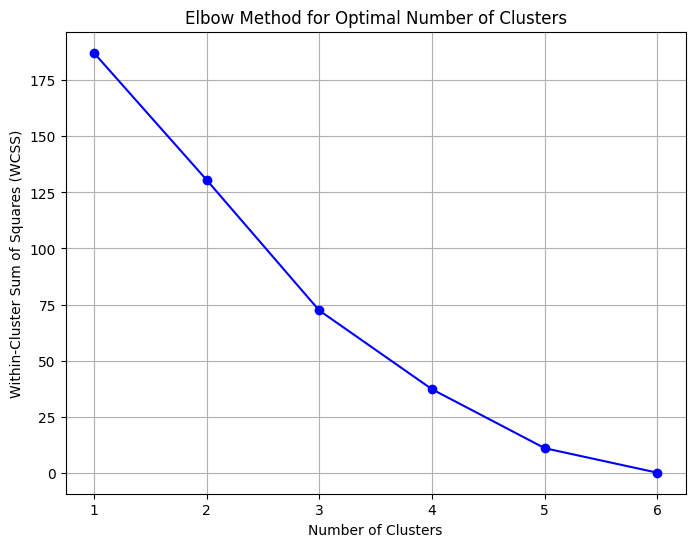

In [12]:
elbow_method(embed, len(texts))

### Попробуем DBSCAN

In [13]:
embeddings = []
for text in texts:
    tokens = tokenizer(text, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**tokens)
        text_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    embeddings.append(text_embedding)

embeddings = np.array(embeddings)

dbscan = DBSCAN(eps=0.7, min_samples=1)
cluster_labels = dbscan.fit_predict(embeddings)

results_df = pd.DataFrame({
    'Text': texts,
    'Cluster_Label': cluster_labels
})

print(results_df)

                                                Text  Cluster_Label
0  Создание морфологического парсера андийского я...              0
1  Создание морфологического парсера для чамалинс...              1
2  Создание морфологического парсера андийского я...              0
3   Языковая ситуация в эстонской диаспоре в Сибири.              2
4  Динамика языковой ситуации в Казахстане в нове...              3
5         Поэтический корпус древнегреческого языка.              4
6                          корпус английского языка.              5


DBSCAN намного хуже справляется с поставленной задачей. Кластера идут в разнобой.

### Кластеризуем тексты аннотаций работ студентов

In [15]:
df = pd.read_csv("data_base.csv", header=None)

In [519]:
df.head()

0  \
0  Предсказание параметров генерации ответа диало...   
1  Использование памяти в генеративных диалоговых...   
2  Применение методов объяснимого искусственного ...   
3  Извелечение именованных сущностей из документо...   
4  Автоматическое выделение лексико-семантических...   

                               1                                 2  \
0  Гавришина Екатерина Ильинична       Ляшевская Ольга Николаевна    
1   Зайцев Константин Николаевич         Толдова Светлана Юрьевна    
2  Выдрина Светлана Владимировна  Клышинский Эдуард Станиславович    
3   Грязнова Екатерина Сергеевна           Макаров Илья Андреевич    
4      Богданова Анна Евгеньевна  Клышинский Эдуард Станиславович    

              3    4     5                                                  6  \
0  Магистратура  7.0  2023  В данном исследовании рассматривается проблема...   
1  Магистратура  9.0  2023  В данном исследовании представлена реализация ...   
2  Магистратура  9.0  2023  Выпускная квалификационная работа посвящена пр...   
3  Магистратура  8.0  2023  Это исследование посвящено задаче распознавани...   
4  Магистратура  9.0  2023  Разработка методов автоматического извлечения ...   

                                                   7  
0  https://lms.hse.ru/ap_service.php?getwork=1&gu...  
1  https://lms.hse.ru/ap_service.php?getwork=1&gu...  
2  https://lms.hse.ru/ap_service.php?getwork=1&gu...  
3  https://lms.hse.ru/ap_service.php?getwork=1&gu...  
4  https://lms.hse.ru/ap_service.php?getwork=1&gu...

In [16]:
df = df[[0, 2, 3, 4, 5, 6]].rename({0:"name", 2:"lecturer", 3:"degree", 4:"grade", 5:"year", 6:"annotation"}, axis=1)

In [17]:
df = df.dropna(subset=['grade'])

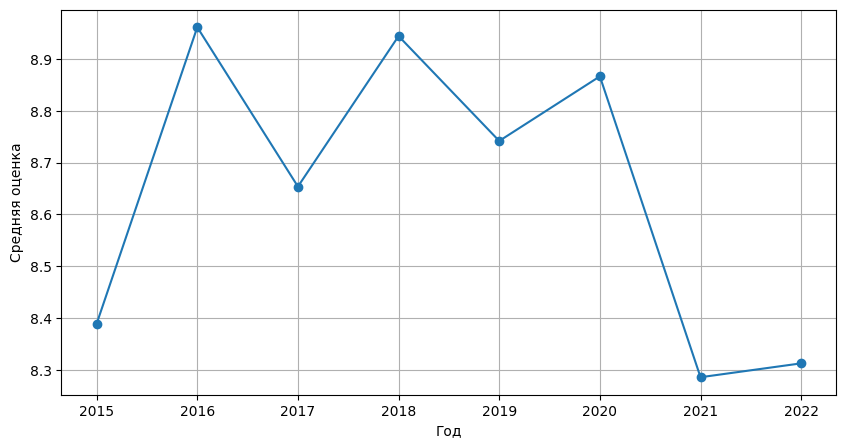

In [18]:
# Средняя оценка по годам
average_grade_by_year = df.groupby('year')['grade'].mean()

# Топ преподов по средней оценке
top_lecturers = df.groupby('lecturer')['grade'].mean()
plt.figure(figsize=(10, 5))
plt.plot(average_grade_by_year.index, average_grade_by_year.values, marker='o')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.xlabel('Год')
plt.ylabel('Средняя оценка')
plt.grid(True)
plt.show()

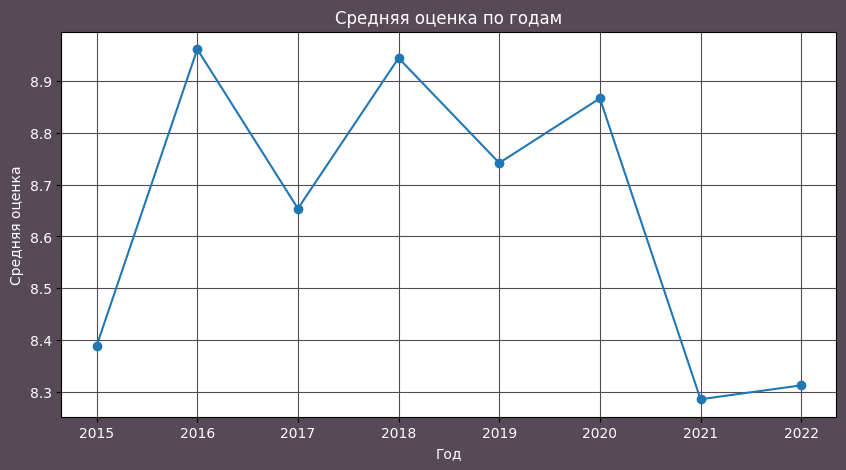

In [19]:
background_color = (0.34, 0.29, 0.34)
white_color = (1, 1, 1)
plt.rcParams['figure.facecolor'] = 'black'
plt.figure(figsize=(10, 5), facecolor=background_color)
plt.plot(average_grade_by_year.index, average_grade_by_year.values, marker='o')
plt.title('Средняя оценка по годам', color=white_color)
plt.xlabel('Год', color=white_color)
plt.ylabel('Средняя оценка', color=white_color)
plt.xticks(color='w')
plt.yticks(color='w')
plt.grid(True, color=background_color)
plt.rcParams['figure.facecolor'] = 'black'
plt.show()

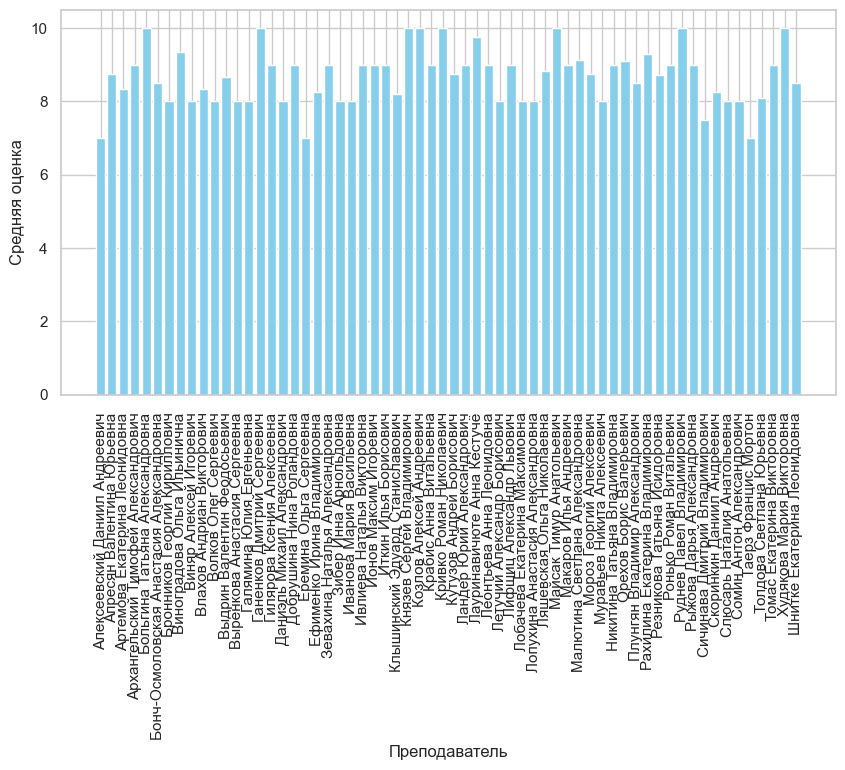

In [28]:
plt.figure(figsize=(10, 5))
plt.bar(top_lecturers.index, top_lecturers.values, color='skyblue')
plt.xlabel('Преподаватель')
plt.ylabel('Средняя оценка')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

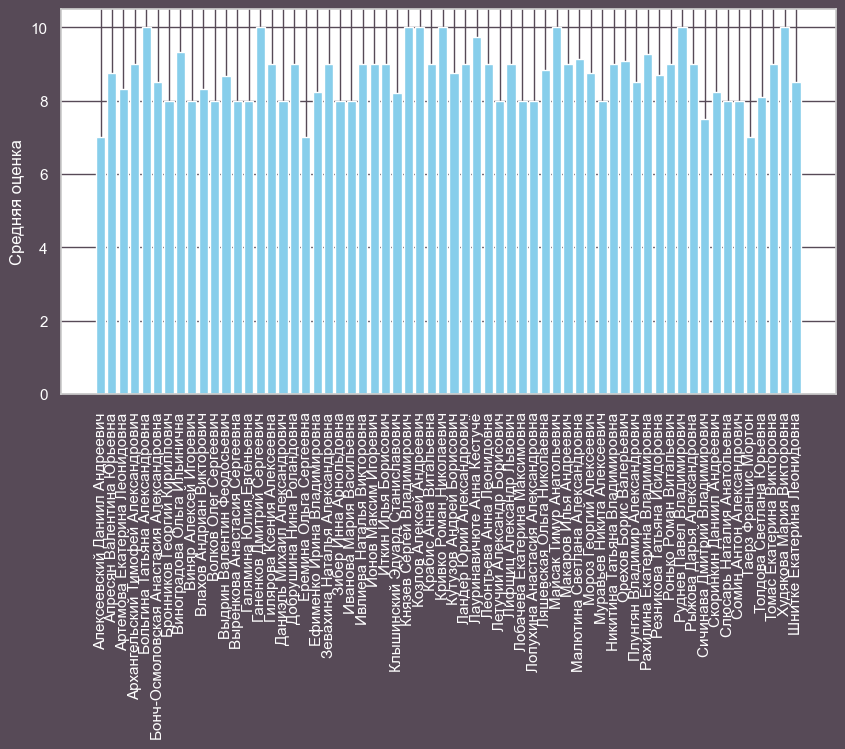

In [29]:
plt.figure(figsize=(10, 5), facecolor=background_color)
plt.bar(top_lecturers.index, top_lecturers.values, color='skyblue')
# plt.xlabel('Преподаватель')
plt.ylabel('Средняя оценка', color=white_color)
plt.xticks(rotation=90)
plt.xticks(color='w')
plt.yticks(color='w')
plt.grid(True, color=background_color)
plt.show()

In [22]:
df['grade'].value_counts()

grade
10.0    58
9.0     54
8.0     49
7.0     33
Name: count, dtype: int64

In [23]:
sns.set(style="whitegrid")
sns.histplot(data=df, x="grade", bins=10, kde=True)

<Axes: xlabel='grade', ylabel='Count'>

In [24]:
df = df.dropna()

In [34]:
embed = get_embed(df.annotation.values)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-p

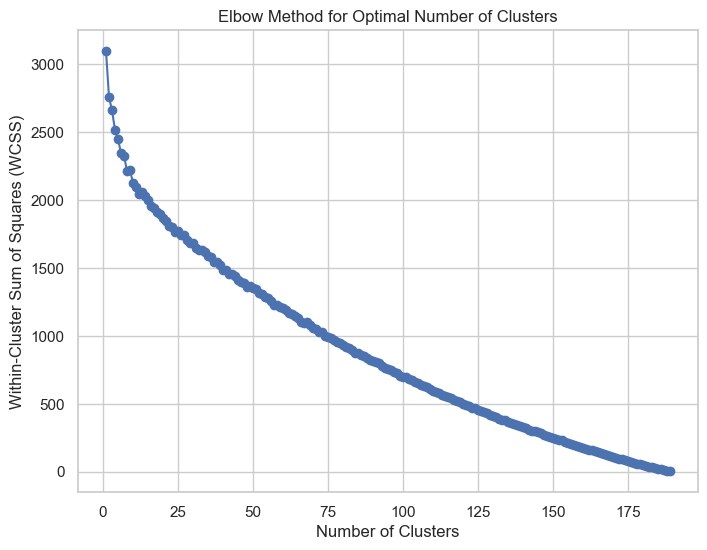

In [35]:
elbow_method(embed , len(df.annotation))

Судя по графику, можно предположить, что оптимальное k колеблется в районе 10-30

#### Пробуем ruBERT над аннотациями работ

In [37]:
embeddings = []
for text in df.annotation.values:
    tokens = tokenizer(text, return_tensors="pt",  max_length=512)

    with torch.no_grad():
        outputs = model(**tokens)
        text_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    embeddings.append(text_embedding)

embeddings = np.array(embeddings)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [77]:
num_clusters = 12
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings)
cluster_labels = kmeans.labels_
df['Cluster_Label'] = cluster_labels

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [78]:
df['Cluster_Label'].value_counts()

Cluster_Label
3     29
0     29
7     27
1     26
10    25
11    22
2     21
9      5
8      2
4      2
5      1
6      1
Name: count, dtype: int64

In [79]:
df[df['Cluster_Label'] == 9]['name'].to_list()

['Языковая ситуация в сообществе российских цыган и его языковая идентичность',
 'Тематическое моделирование междисциплинарности в выпускных квалификационных работах студентов ФГН НИУ ВШЭ',
 'Конструирование образа России в современном российском визуальном искусстве и применение полученных данных в преподавании РКИ',
 'Формирование языковой идентичности российских глухих: проблемы и перспективы',
 '"Перед сносом снять": цифровой фотоархив исторических домов Басманного района, попадающих под реновацию']

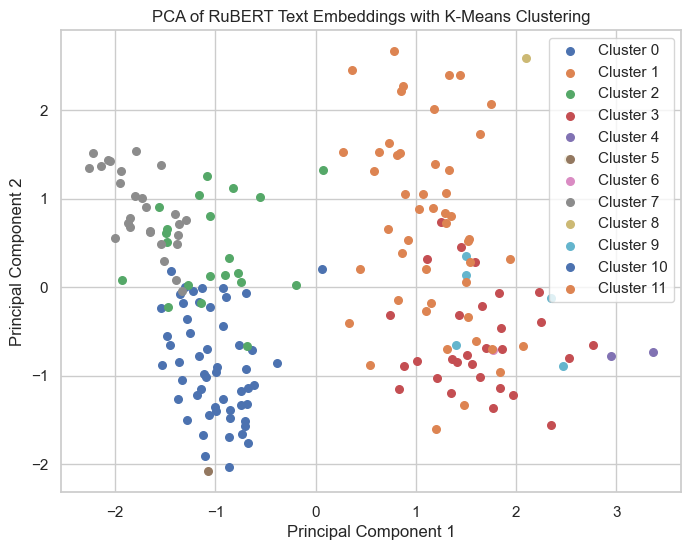

In [80]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

unique_labels = set(cluster_labels)
plt.figure(figsize=(8, 6))
for label in unique_labels:
    plt.scatter(reduced_embeddings[cluster_labels == label, 0], reduced_embeddings[cluster_labels == label, 1], s=30, label=f'Cluster {label}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of RuBERT Text Embeddings with K-Means Clustering')
plt.legend()
plt.show()

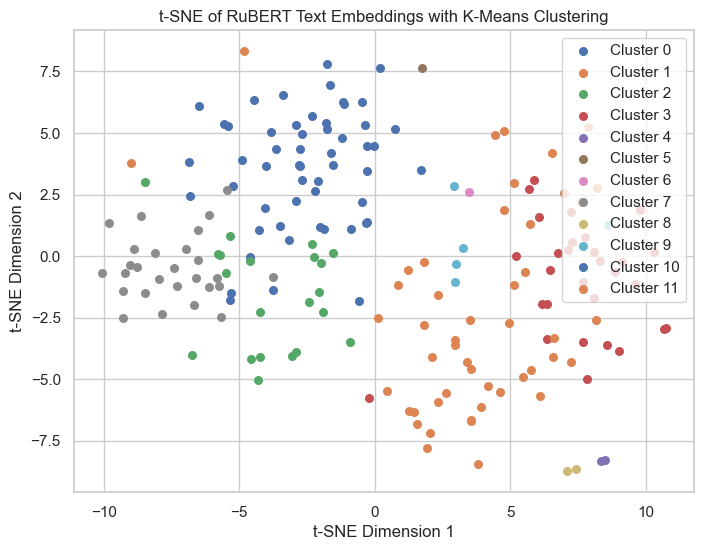

In [81]:
tsne = TSNE(n_components=2, random_state=0)
reduced_embeddings = tsne.fit_transform(embeddings)

unique_labels = set(cluster_labels)
plt.figure(figsize=(8, 6))
for label in unique_labels:
    plt.scatter(reduced_embeddings[cluster_labels == label, 0], reduced_embeddings[cluster_labels == label, 1], s=30, label=f'Cluster {label}')

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE of RuBERT Text Embeddings with K-Means Clustering')
plt.legend()
plt.show()

In [82]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [83]:
silhouette_avg = silhouette_score(embeddings , cluster_labels)
db_index= davies_bouldin_score(embeddings  , cluster_labels)
silhouette_avg,db_index

(0.0411173, 2.5419011406699763)

In [84]:
metrics_data = {
    'Model': [model_name, model_name],
    'Metric': ['Silhouette Score', 'Davies-Bouldin Index'],
    'Value': [silhouette_avg, db_index]
}

metrics_df = pd.DataFrame(metrics_data)

In [85]:
metrics_df 

Model                Metric     Value
0  DeepPavlov/rubert-base-cased      Silhouette Score  0.041117
1  DeepPavlov/rubert-base-cased  Davies-Bouldin Index  2.541901

Судя по всему, тексты работ являются довольно похожими между собой, что мешает формированию кластеров. Попробуем применить ruBERT над названиями работ

#### ruBERT над названиями работ

In [86]:
embeddings = []
for text in df.name.values:
    tokens = tokenizer(text, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**tokens)
        text_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    embeddings.append(text_embedding)

embeddings = np.array(embeddings)

num_clusters = 50
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings)
cluster_labels = kmeans.labels_
df['Cluster_Label'] = cluster_labels

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [87]:
df['Cluster_Label'].value_counts()

Cluster_Label
14    15
11    11
27     8
12     8
2      8
10     8
40     8
23     7
22     7
1      7
44     6
39     6
18     6
4      5
6      5
9      5
21     4
7      4
38     4
46     4
3      4
25     3
29     3
20     3
36     3
13     3
8      3
32     3
30     3
5      2
17     2
37     2
35     2
24     2
33     1
0      1
26     1
47     1
15     1
16     1
28     1
34     1
19     1
48     1
43     1
41     1
42     1
45     1
49     1
31     1
Name: count, dtype: int64

In [516]:
# df[df['Cluster_Label'] == 19]['name'].to_list()

In [88]:
silhouette_avg = silhouette_score(embeddings , cluster_labels)
db_index= davies_bouldin_score(embeddings  , cluster_labels)
silhouette_avg,db_index

(0.022953274, 1.7808155454524819)

In [92]:
metrics_df.loc[2]=[model_name,'Silhouette Score',silhouette_avg ]
metrics_df.loc[3]=[model_name,'Davies-Bouldin Index',db_index ]

In [93]:
metrics_df

Model                Metric     Value
0  DeepPavlov/rubert-base-cased      Silhouette Score  0.041117
1  DeepPavlov/rubert-base-cased  Davies-Bouldin Index  2.541901
2  DeepPavlov/rubert-base-cased      Silhouette Score  0.022953
3  DeepPavlov/rubert-base-cased  Davies-Bouldin Index  1.780816

##### PCA

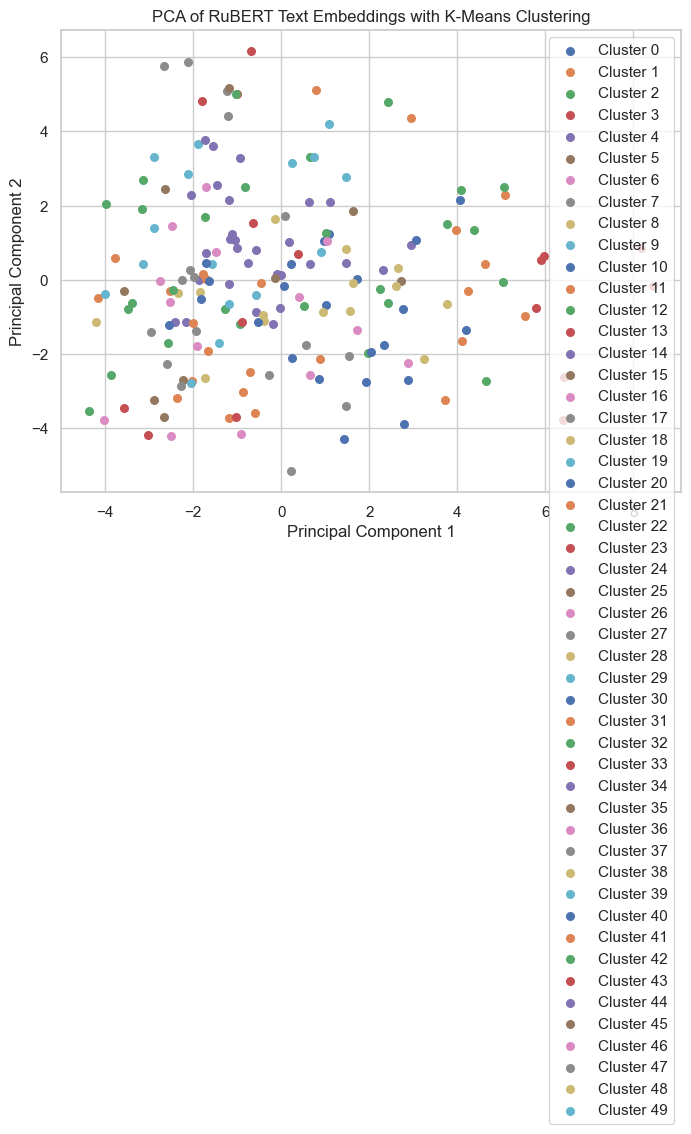

In [94]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

unique_labels = set(cluster_labels)
plt.figure(figsize=(8, 6))
for label in unique_labels:
    plt.scatter(reduced_embeddings[cluster_labels == label, 0], reduced_embeddings[cluster_labels == label, 1], s=30, label=f'Cluster {label}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of RuBERT Text Embeddings with K-Means Clustering')
plt.legend()
plt.show()

##### t-SNE

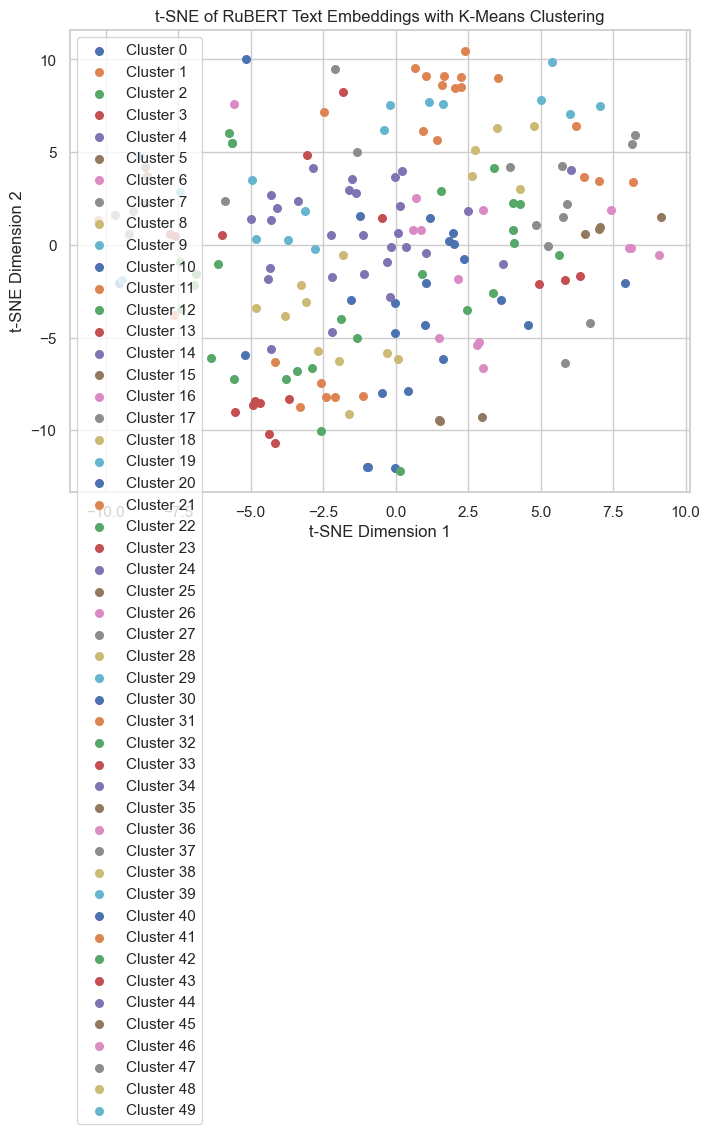

In [95]:
tsne = TSNE(n_components=2, random_state=0)
reduced_embeddings = tsne.fit_transform(embeddings)

unique_labels = set(cluster_labels)
plt.figure(figsize=(8, 6))
for label in unique_labels:
    plt.scatter(reduced_embeddings[cluster_labels == label, 0], reduced_embeddings[cluster_labels == label, 1], s=30, label=f'Cluster {label}')

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE of RuBERT Text Embeddings with K-Means Clustering')
plt.legend()
plt.show()

### Попробуем TF-IDF

In [96]:
import stop_words
texts = df.annotation.values
russian_stopwords = stop_words.get_stop_words('ru')
russian_stopwords.extend(['...', '«', '»', 'здравствуйте','здравствуй','до свидания', 'добрый день', 'добрый вечер', 'доброе утро'])
import string
def remove_punctuation(text):
    return ''.join([ch if ch not in string.punctuation else ' ' for ch in text])
def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])
import re
def remove_multiple_spaces(text):
    return re.sub(r'\s+', ' ', text, flags=re.I)

prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in texts.astype('str')]
df['text_prep'] = prep_text
df.head()

name  \
10  Автоматическое выделение толкований терминов в...   
14               Лексическая типология зоны 'попасть'   
17  Автоматическое определение жанра песни по текс...   
22  Определение шкалы композициональности в простр...   
27  Влияние ингибиторного контроля на лексический ...   

                            lecturer       degree  grade  year  \
10       Ляшевская Ольга Николаевна   Бакалавриат    9.0  2022   
14       Рыжова Дарья Александровна   Бакалавриат    8.0  2022   
17       Ляшевская Ольга Николаевна   Бакалавриат    8.0  2022   
22       Ляшевская Ольга Николаевна   Бакалавриат    8.0  2022   
27  Малютина Светлана Александровна   Бакалавриат    9.0  2022   

                                           annotation  Cluster_Label  \
10  Автоматическое выделение определений из корпус...             27   
14  На первый взгляд кажется, что семантическая зо...             43   
17  Автоматическое определение музыкальных жанров ...             27   
22  Принцип композициональности в общем виде гласи...              4   
27  Лексическому доступу монолингв и их способност...             39   

                                            text_prep  
10  автоматическое выделение определений из корпус...  
14  на первый взгляд кажется что семантическая зон...  
17  автоматическое определение музыкальных жанров ...  
22  принцип композициональности в общем виде гласи...  
27  лексическому доступу монолингв и их способност...

In [97]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
lemm_texts_list = []
for text in df['text_prep']:
    text_lem = [morph.parse(word)[0].normal_form for word in text.split(' ')]
    if len(text_lem) <= 2:
        lemm_texts_list.append('')
        continue
    lemm_texts_list.append(' '.join(text_lem))
df['text_lemm'] = lemm_texts_list
df = df[df['text_lemm'] != '']
df.head()

name  \
10  Автоматическое выделение толкований терминов в...   
14               Лексическая типология зоны 'попасть'   
17  Автоматическое определение жанра песни по текс...   
22  Определение шкалы композициональности в простр...   
27  Влияние ингибиторного контроля на лексический ...   

                            lecturer       degree  grade  year  \
10       Ляшевская Ольга Николаевна   Бакалавриат    9.0  2022   
14       Рыжова Дарья Александровна   Бакалавриат    8.0  2022   
17       Ляшевская Ольга Николаевна   Бакалавриат    8.0  2022   
22       Ляшевская Ольга Николаевна   Бакалавриат    8.0  2022   
27  Малютина Светлана Александровна   Бакалавриат    9.0  2022   

                                           annotation  Cluster_Label  \
10  Автоматическое выделение определений из корпус...             27   
14  На первый взгляд кажется, что семантическая зо...             43   
17  Автоматическое определение музыкальных жанров ...             27   
22  Принцип композициональности в общем виде гласи...              4   
27  Лексическому доступу монолингв и их способност...             39   

                                            text_prep  \
10  автоматическое выделение определений из корпус...   
14  на первый взгляд кажется что семантическая зон...   
17  автоматическое определение музыкальных жанров ...   
22  принцип композициональности в общем виде гласи...   
27  лексическому доступу монолингв и их способност...   

                                            text_lemm  
10  автоматический выделение определение из корпус...  
14  на первый взгляд казаться что семантический зо...  
17  автоматический определение музыкальный жанр ко...  
22  принцип композициональность в общий вид гласит...  
27  лексический доступ монолингть и они способност...

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(analyzer='char', ngram_range =(2,10))
texts_vecs = tfidf_vec.fit_transform(df['text_lemm'])

##### t-SNE

In [100]:
tsne = TSNE(n_components=2, random_state=0)
tsne_transformed = tsne.fit_transform(texts_vecs.toarray())

##### PCA

In [101]:
num_clusters = 30
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(tsne_transformed)
cluster_labels = kmeans.labels_

results_df = pd.DataFrame({
    'Text': df.annotation.values,
    'Cluster_Label': cluster_labels
})

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [102]:
results_df['Cluster_Label'].value_counts()

Cluster_Label
14    11
11    11
7     11
1     10
9     10
20    10
24     9
22     8
18     8
5      7
4      7
23     7
15     6
27     6
6      6
10     6
28     6
13     6
17     5
3      5
0      5
19     5
26     4
16     4
25     4
2      4
12     3
8      2
29     2
21     2
Name: count, dtype: int64

In [103]:
results_df[results_df['Cluster_Label'] == 22]['Text'].value_counts()

Text
Чувством “на кончике языка” называют состояние, при котором у говорящего есть сильное ощущение того, что он знает слово, оно словно “вертится на языке”, но в данный момент он не может это слово воспроизвести. Есть множество статей, которые исследуют, как разные типы подсказок влияют на разрешение состояния “на кончике языка”. Однако остается неисследованным, какой тип семантических подсказок помогает лучше. Целью данного исследования было выяснить, какой тип семантических подсказок (когипоним или ассоциация) лучше помогает в облегчении состояния “на кончике языка”. Мы провели эксперимент, в котором участники должны были называть слова по их определениям, а затем, если они не могли вспомнить слово, предъявлялись подсказки - ассоциации или когипонимы к целевому слову, которые должны были помочь извлечению целевого слова. Также мы спрашивали участников, испытывали ли они чувство “на кончике языка”, если не могли вспомнить слово. Проводя исследование, мы рассчитывали, что состояние “н

#### PCA

In [104]:
num_clusters = 15
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(texts_vecs)
cluster_labels = kmeans.labels_

results_df = pd.DataFrame({
    'Text': df.annotation.values,
    'Cluster_Label': cluster_labels
})

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [105]:
for cluster_label in range(num_clusters):
    cluster_points = tfidf_pca[cluster_labels == cluster_label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_label}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('TF-IDF Clustering with PCA')
plt.legend()
plt.show()

NameError: name 'tfidf_pca' is not defined

##### DBSCAN (не сработало)

In [75]:
# dbscan = DBSCAN(eps=0.7, min_samples=1)  # Adjust parameters as needed
# dbscan_labels = dbscan.fit_predict(texts_vecs)

In [86]:
# unique_labels = set(dbscan_labels)
# colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
# plt.figure(figsize=(8, 6))
# for label, color in zip(unique_labels, colors):
#     if label == -1:
#         plt.scatter(texts_vecs[dbscan_labels == label, 0].toarray(),
#                     texts_vecs[dbscan_labels == label, 1].toarray(), c='k', s=30, label='Noise')
#     else:
#         plt.scatter(texts_vecs[dbscan_labels == label, 0].toarray(),
#                     texts_vecs[dbscan_labels == label, 1].toarray(), c=color, s=30, label=f'Cluster {label}')

# plt.xlabel('TF-IDF Feature 1')
# plt.ylabel('TF-IDF Feature 2')
# plt.title('DBSCAN Clustering (TF-IDF)')
# plt.legend()
# plt.show()

In [106]:
results_df['Cluster_Label'].value_counts()

Cluster_Label
3     34
1     25
9     25
5     17
6     16
7     15
14    13
12    11
2      9
8      8
13     5
4      4
10     3
0      3
11     2
Name: count, dtype: int64

In [107]:
results_df[results_df['Cluster_Label'] == 13]['Text'].to_list()

['Аннотация на русском',
 'Самый большой международный цифровой словообразовательный ресурс называется Universal Derivations. Он содержит гармонизированные данные из 11 индоевропейских языков. Данных русского языка в Universal Derivations пока нет. Наша задача – создать базу словообразовательных данных русского языка в формате Universal Derivations и оценить, насколько хорошо методы, эффективно работающие с данными по деривациям в языках, представленных в Universal Derivations, справляются с русскими данными. Для создания базы данных используются классификаторы Logistic Regression и Decision Trees, а так же алгоритм Maximum Spanning Tree.',
 'Работа посвящена созданию системы, позволяющей упростить разметку Русского учебного корпуса. Система, основанная на алгоритмах классификации, предназначена для автоматического распознавания типа ошибки при аннотации после того как ошибка была исправлена разметчиком вручную. Система работает не для всех типов ошибок, но показала удовлетворительные 

### Попробуем на названиях

In [108]:
import stop_words
texts = df.name.values
russian_stopwords = stop_words.get_stop_words('ru')
russian_stopwords.extend(['...', '«', '»', 'здравствуйте','здравствуй','до свидания', 'добрый день', 'добрый вечер', 'доброе утро'])
import string
def remove_punctuation(text):
    return ''.join([ch if ch not in string.punctuation else ' ' for ch in text])
def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])
import re
def remove_multiple_spaces(text):
    return re.sub(r'\s+', ' ', text, flags=re.I)

prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in texts.astype('str')]
df['text_prep'] = prep_text
df.head()

name  \
10  Автоматическое выделение толкований терминов в...   
14               Лексическая типология зоны 'попасть'   
17  Автоматическое определение жанра песни по текс...   
22  Определение шкалы композициональности в простр...   
27  Влияние ингибиторного контроля на лексический ...   

                            lecturer       degree  grade  year  \
10       Ляшевская Ольга Николаевна   Бакалавриат    9.0  2022   
14       Рыжова Дарья Александровна   Бакалавриат    8.0  2022   
17       Ляшевская Ольга Николаевна   Бакалавриат    8.0  2022   
22       Ляшевская Ольга Николаевна   Бакалавриат    8.0  2022   
27  Малютина Светлана Александровна   Бакалавриат    9.0  2022   

                                           annotation  Cluster_Label  \
10  Автоматическое выделение определений из корпус...             27   
14  На первый взгляд кажется, что семантическая зо...             43   
17  Автоматическое определение музыкальных жанров ...             27   
22  Принцип композициональности в общем виде гласи...              4   
27  Лексическому доступу монолингв и их способност...             39   

                                            text_prep  \
10  автоматическое выделение толкований терминов в...   
14                лексическая типология зоны попасть    
17  автоматическое определение жанра песни по текс...   
22  определение шкалы композициональности в простр...   
27  влияние ингибиторного контроля на лексический ...   

                                            text_lemm  
10  автоматический выделение определение из корпус...  
14  на первый взгляд казаться что семантический зо...  
17  автоматический определение музыкальный жанр ко...  
22  принцип композициональность в общий вид гласит...  
27  лексический доступ монолингть и они способност...

In [109]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
lemm_texts_list = []
for text in df['text_prep']:
    text_lem = [morph.parse(word)[0].normal_form for word in text.split(' ')]
    if len(text_lem) <= 2:
        lemm_texts_list.append('')
        continue
    lemm_texts_list.append(' '.join(text_lem))
df['text_lemm'] = lemm_texts_list
df = df[df['text_lemm'] != '']
df.head()

name  \
10  Автоматическое выделение толкований терминов в...   
14               Лексическая типология зоны 'попасть'   
17  Автоматическое определение жанра песни по текс...   
22  Определение шкалы композициональности в простр...   
27  Влияние ингибиторного контроля на лексический ...   

                            lecturer       degree  grade  year  \
10       Ляшевская Ольга Николаевна   Бакалавриат    9.0  2022   
14       Рыжова Дарья Александровна   Бакалавриат    8.0  2022   
17       Ляшевская Ольга Николаевна   Бакалавриат    8.0  2022   
22       Ляшевская Ольга Николаевна   Бакалавриат    8.0  2022   
27  Малютина Светлана Александровна   Бакалавриат    9.0  2022   

                                           annotation  Cluster_Label  \
10  Автоматическое выделение определений из корпус...             27   
14  На первый взгляд кажется, что семантическая зо...             43   
17  Автоматическое определение музыкальных жанров ...             27   
22  Принцип композициональности в общем виде гласи...              4   
27  Лексическому доступу монолингв и их способност...             39   

                                            text_prep  \
10  автоматическое выделение толкований терминов в...   
14                лексическая типология зоны попасть    
17  автоматическое определение жанра песни по текс...   
22  определение шкалы композициональности в простр...   
27  влияние ингибиторного контроля на лексический ...   

                                            text_lemm  
10  автоматический выделение толкование термин в к...  
14                лексический типология зона попасть   
17  автоматический определение жанр песня по текст...  
22  определение шкала композициональность в простр...  
27  влияние ингибиторный контроль на лексический д...

In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(analyzer='char', ngram_range =(2,10), max_features=1000)
texts_vecs_name = tfidf_vec.fit_transform(df['text_lemm'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


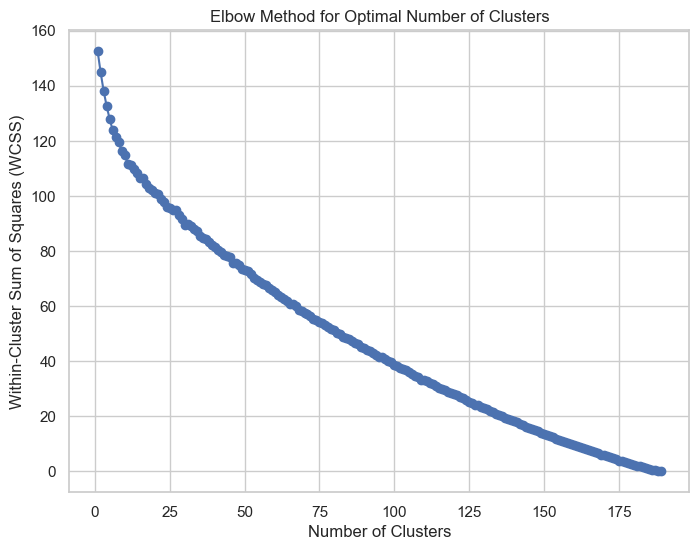

In [112]:
elbow_method(texts_vecs_name, len(df.name))

In [113]:
num_clusters = 15
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(texts_vecs_name)
cluster_labels = kmeans.labels_
df['Cluster_Label'] = cluster_labels

In [114]:
df['Cluster_Label'].value_counts()

Cluster_Label
6     25
5     21
8     20
3     18
0     17
4     17
9     14
12    11
1      9
2      8
13     7
7      7
14     6
11     5
10     5
Name: count, dtype: int64

In [115]:
df[df['Cluster_Label'] == 6]['name'].value_counts()

name
Сравнение статистики ошибок употребления падежей в текстах на русском языке                                                                         1
Машинный перевод немецких составных слов на русский язык                                                                                            1
Порядок слов в русских словосочетаниях и предложениях: основные сложности и ошибки изучающих русский язык как иностранный                           1
Сравнительное описание дискурсивных формул отказа и отрицания в русском и английском языках                                                         1
Когнитивные схемы модальных слов возможности и эпистемическое употребление модальных слов возможности в русском и японском языках                   1
Нарративная инверсия, топикальность и референциальный статус в русском языке                                                                        1
Средства выражения значения одновременности в русском жестовом языке                           

In [116]:
svd = TruncatedSVD(n_components=2)
reduced_embeddings = svd.fit_transform(texts_vecs_name)

unique_labels = set(cluster_labels)
plt.figure(figsize=(8, 6))
for label in unique_labels:
    plt.scatter(reduced_embeddings[cluster_labels == label, 0], reduced_embeddings[cluster_labels == label, 1], s=30, label=f'Cluster {label}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVD of Tf-Idf with K-Means Clustering')
plt.legend()
plt.show()

NameError: name 'TruncatedSVD' is not defined

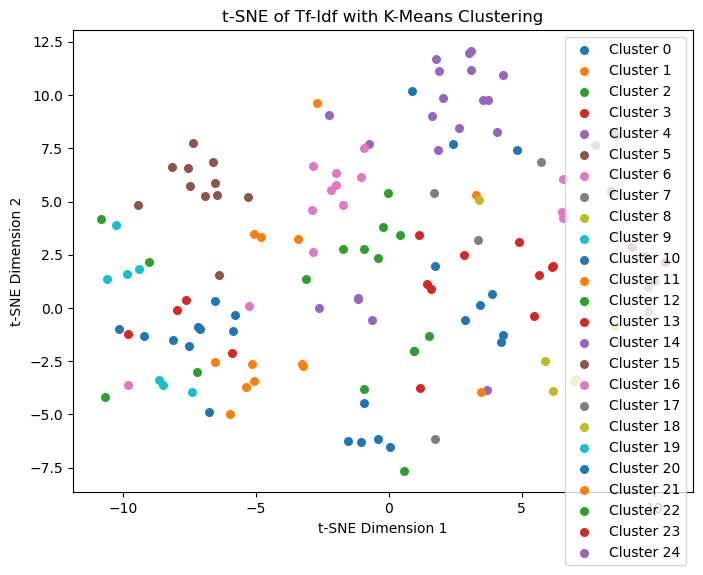

In [413]:
tsne = TSNE(n_components=2, random_state=0)
reduced_embeddings = tsne.fit_transform(texts_vecs_name)

unique_labels = set(cluster_labels)
plt.figure(figsize=(8, 6))
for label in unique_labels:
    plt.scatter(reduced_embeddings[cluster_labels == label, 0], reduced_embeddings[cluster_labels == label, 1], s=30, label=f'Cluster {label}')

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE of Tf-Idf with K-Means Clustering')
plt.legend()
plt.show()

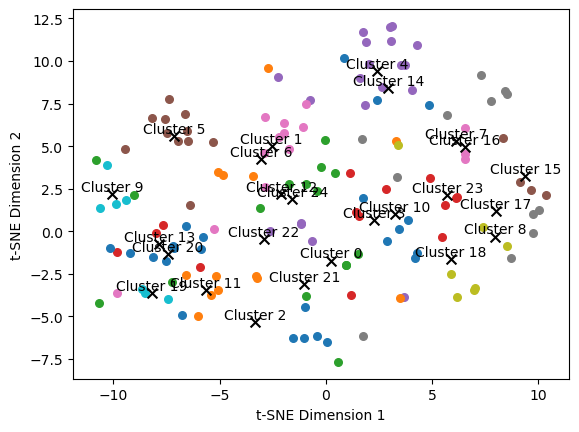

In [564]:
for label in unique_labels:
    plt.scatter(reduced_embeddings[cluster_labels == label, 0], reduced_embeddings[cluster_labels == label, 1], s=30, label=f'Cluster {label}')

for label in unique_labels:
    cluster_points = reduced_embeddings[cluster_labels == label]
    x_center, y_center = np.mean(cluster_points, axis=0)
    plt.scatter(x_center, y_center, c='black', marker='x', s=50, label=f'Cluster {label} Center')
    plt.annotate(f'Cluster {label}', (x_center, y_center), fontsize=10, ha='center', va='bottom')

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
# plt.title('t-SNE of RuBERT Text Embeddings with K-Means Clustering')
# plt.legend()
plt.show()

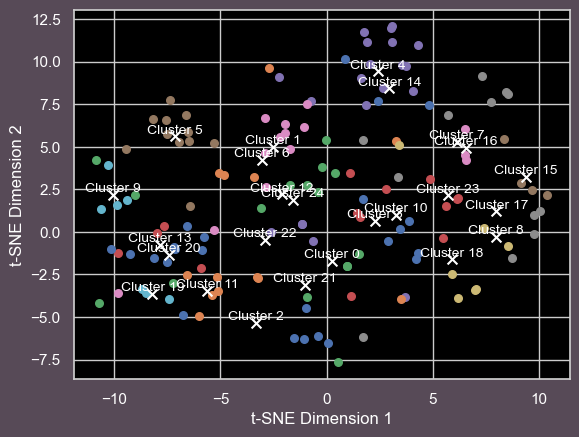

In [630]:
plt.figure(facecolor=background_color)

for label in unique_labels:
    plt.scatter(reduced_embeddings[cluster_labels == label, 0], reduced_embeddings[cluster_labels == label, 1], s=30, label=f'Cluster {label}')

for label in unique_labels:
    cluster_points = reduced_embeddings[cluster_labels == label]
    x_center, y_center = np.mean(cluster_points, axis=0)
    plt.scatter(x_center, y_center, c='w', marker='x', s=50, label=f'Cluster {label} Center')
    plt.annotate(f'Cluster {label}', (x_center, y_center), fontsize=10, ha='center', va='bottom', color='white')

plt.xlabel('t-SNE Dimension 1', color='w')
plt.ylabel('t-SNE Dimension 2', color='w')
plt.xticks(color='w')
plt.yticks(color='w')
# plt.title('t-SNE of RuBERT Text Embeddings with K-Means Clustering')
# plt.legend()
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

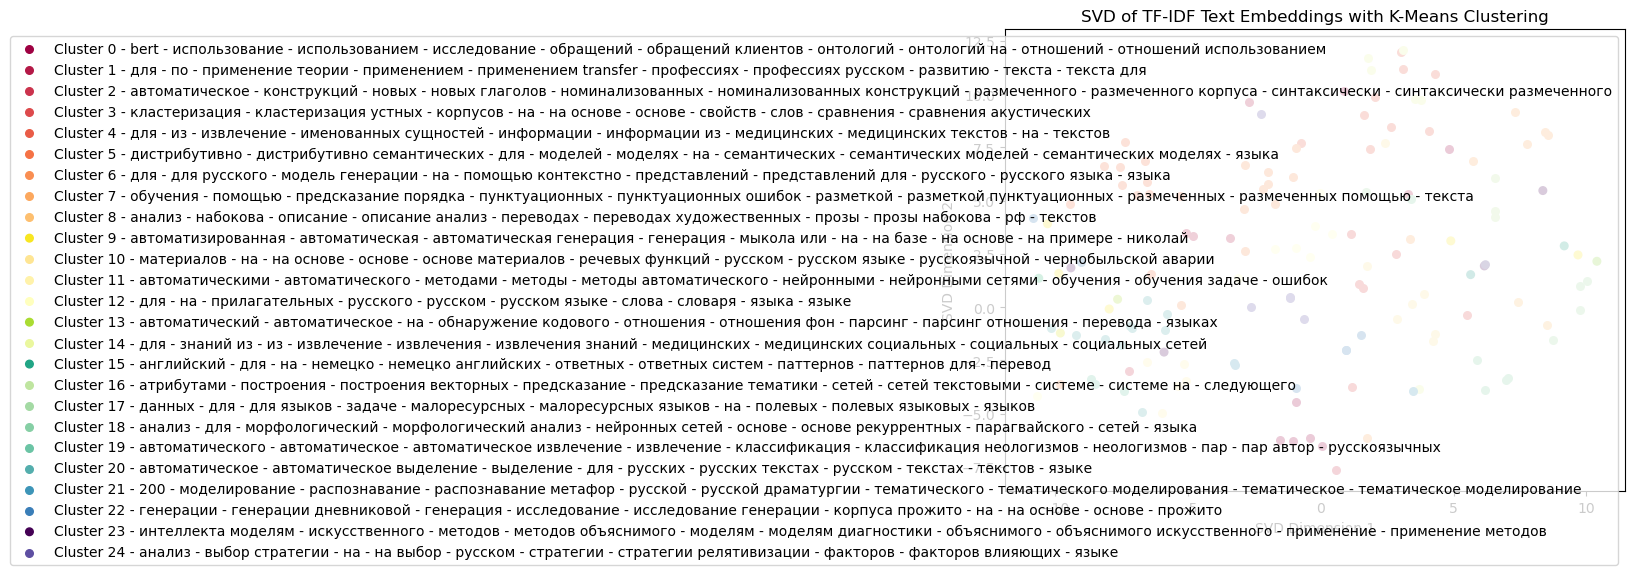

In [462]:
from collections import Counter

cluster_ngrams = {}
for label in set(cluster_labels):
    cluster_indices = np.where(cluster_labels == label)[0]
    cluster_texts = [texts[i] for i in cluster_indices]

    ngram_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10)
    ngram_matrix = ngram_vectorizer.fit_transform(cluster_texts)
    ngram_names = ngram_vectorizer.get_feature_names_out()

    cluster_name = f'Cluster {label} - {" - ".join(ngram_names)}'

    cluster_ngrams[label] = cluster_name

unique_labels = set(cluster_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(8, 6))
for label, color in zip(unique_labels, colors):
    cluster_indices = np.where(cluster_labels == label)[0]

    cluster_name = cluster_ngrams[label]

    plt.scatter(reduced_embeddings[cluster_indices, 0], reduced_embeddings[cluster_indices, 1], c=color, s=30, label=cluster_name)

plt.xlabel('SVD Dimension 1')
plt.ylabel('SVD Dimension 2')
plt.title('SVD of TF-IDF Text Embeddings with K-Means Clustering')
plt.legend()
plt.show()

In [464]:
df[df['Cluster_Label'] == 22]['name'].value_counts()

Исследование генерации дневниковой записи на основе корпуса "Прожито"                     2
Предсказание параметров генерации ответа диалоговой модели                                1
Aвтоматическая генерация сценарных навыков на основе готовых наборов диалоговых данных    1
Генерация комментариев для обучения письму на английском языке                            1
Генерация парафраза на основе архитектуры Transformer                                     1
Name: name, dtype: int64

### LDA

In [229]:
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=russian_stopwords)
dtm = vectorizer.fit_transform(df.annotation.values)

corpus = gensim.matutils.Sparse2Corpus(dtm, documents_columns=False)

id2word = corpora.Dictionary.from_corpus(corpus, id2word=dict((id, word) for word, id in vectorizer.vocabulary_.items()))

num_topics = 20
lda = gensim.models.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=15)

topics = lda.print_topics()
for topic in topics:
    print(topic)

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['вечер', 'доброе', 'добрый', 'свидания', 'утро'] not in stop_words.
  warnings.warn(


(0, '0.007*"ner" + 0.006*"сгенерированных" + 0.005*"помощью" + 0.005*"текстах" + 0.005*"данная" + 0.005*"сравнению" + 0.005*"текстами" + 0.005*"ряд" + 0.005*"устных" + 0.005*"обучении"')
(1, '0.008*"корпуса" + 0.006*"внимания" + 0.005*"анализу" + 0.005*"программы" + 0.005*"должны" + 0.005*"автоматическому" + 0.005*"контекстов" + 0.004*"корпус" + 0.004*"приведены" + 0.004*"алгоритмы"')
(2, '0.006*"веб" + 0.006*"новостей" + 0.006*"идентификации" + 0.006*"биржевых" + 0.006*"эмбеддинги" + 0.005*"интернете" + 0.004*"языковых" + 0.004*"токенов" + 0.004*"данные" + 0.004*"генератора"')
(3, '0.006*"новостей" + 0.006*"связей" + 0.006*"вершин" + 0.006*"главе" + 0.006*"интернет" + 0.005*"повышения" + 0.005*"некоторые" + 0.005*"векторных" + 0.004*"графа" + 0.004*"корпуса"')
(4, '0.007*"разными" + 0.006*"графов" + 0.005*"искусственных" + 0.005*"оценке" + 0.005*"англоязычных" + 0.005*"переводов" + 0.005*"произведения" + 0.005*"персонажей" + 0.005*"машинный" + 0.005*"метрик"')
(5, '0.009*"корпусе" + 0

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use

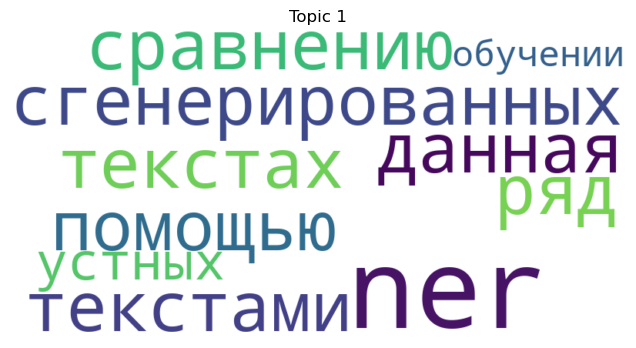

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed i

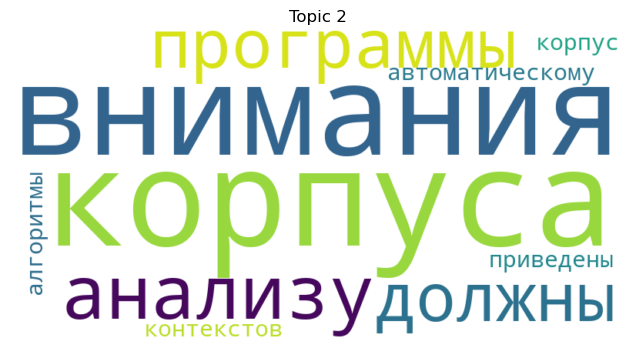

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed i

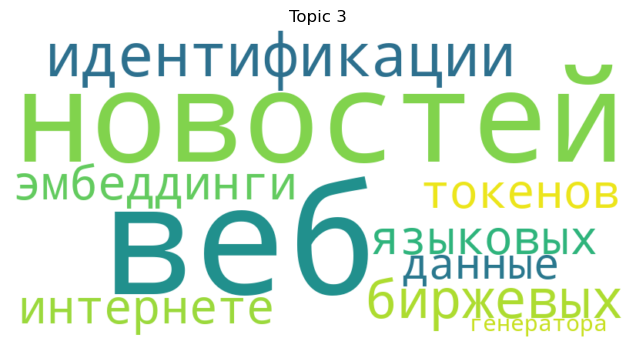

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed i

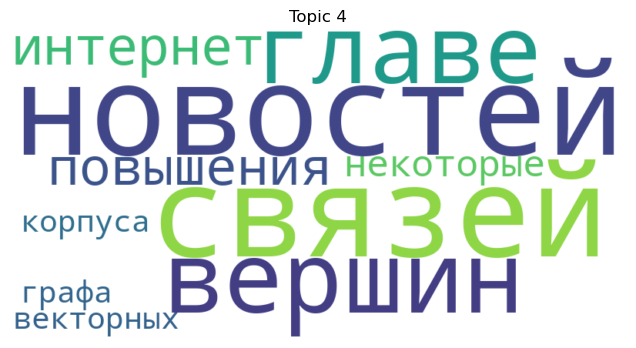

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed i

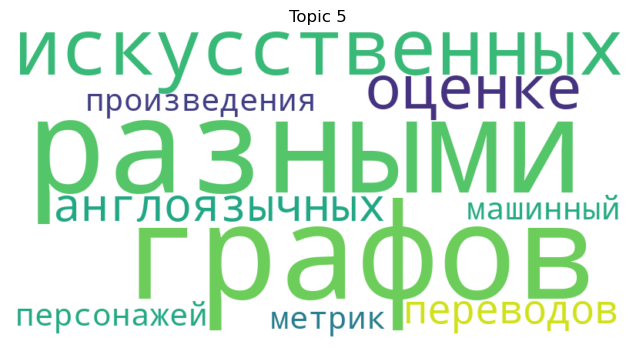

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientatio

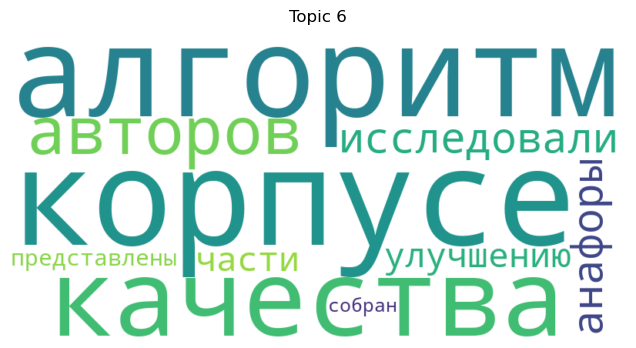

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use

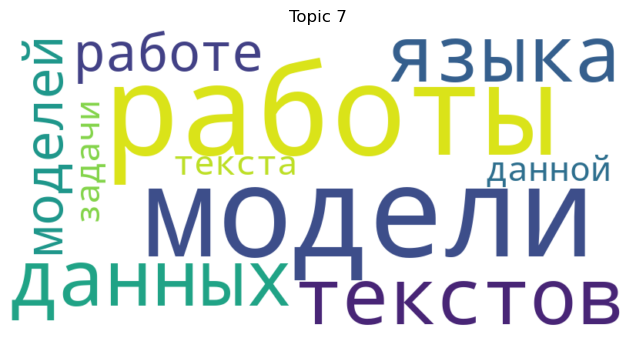

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientatio

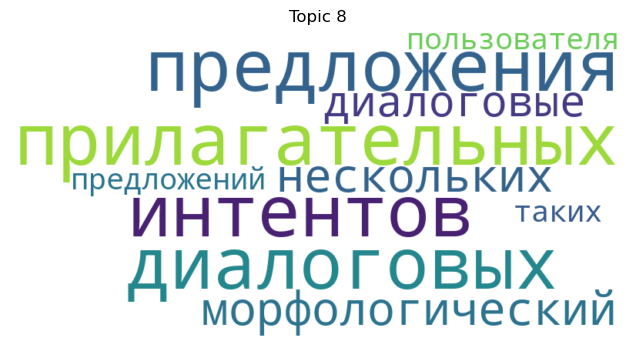

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientatio

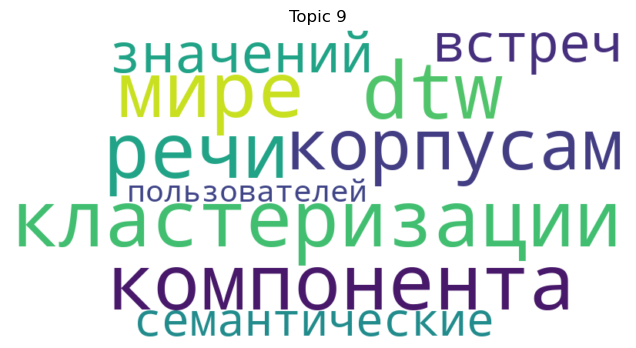

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else


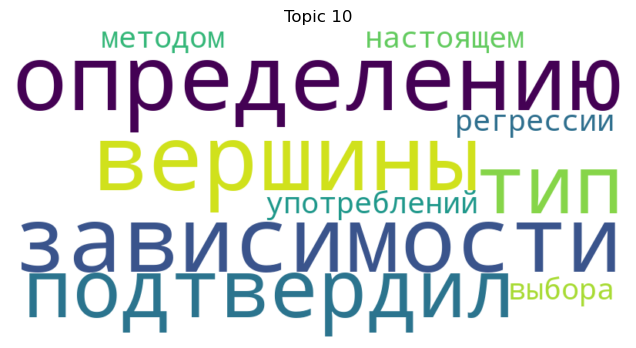

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed i

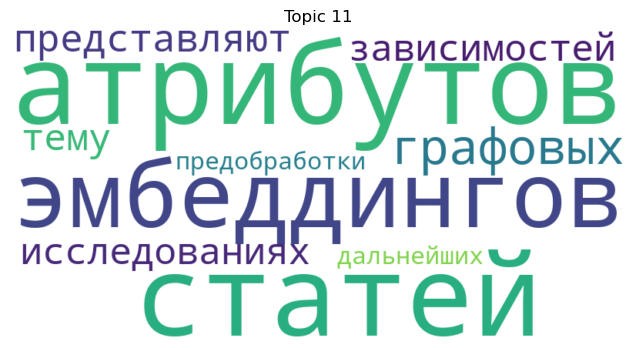

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed i

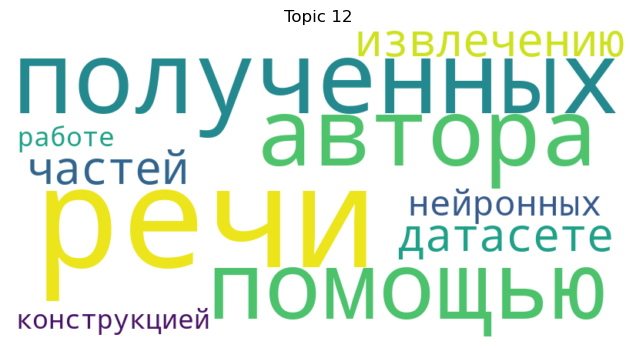

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientatio

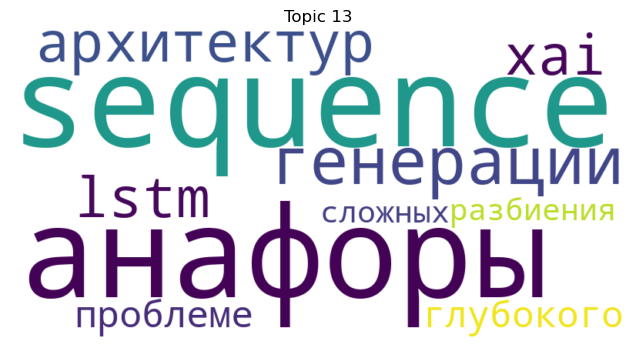

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed i

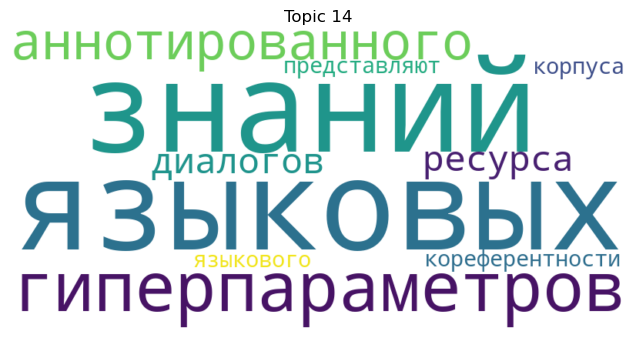

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed i

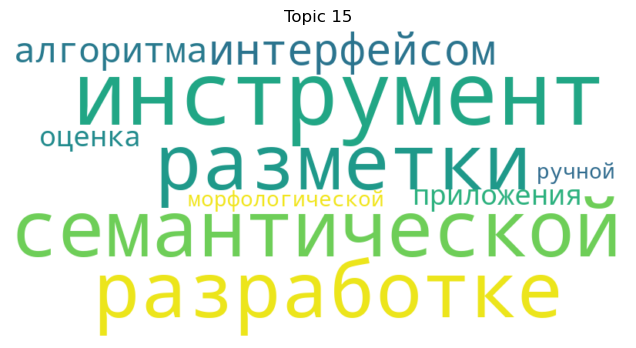

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use

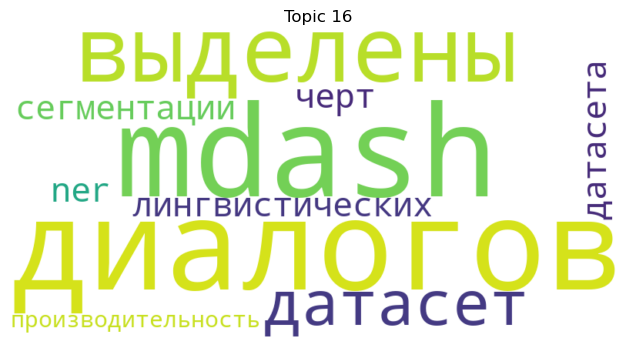

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/Users/gennadiymakhmud

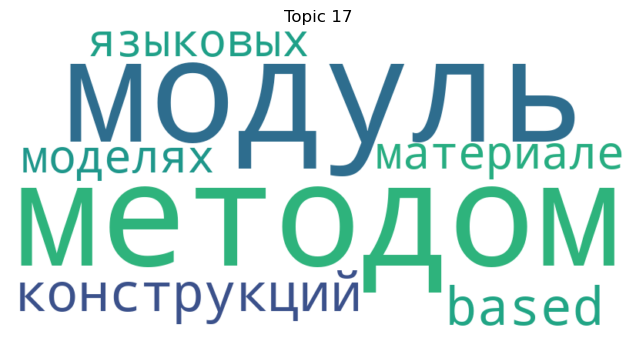

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed i

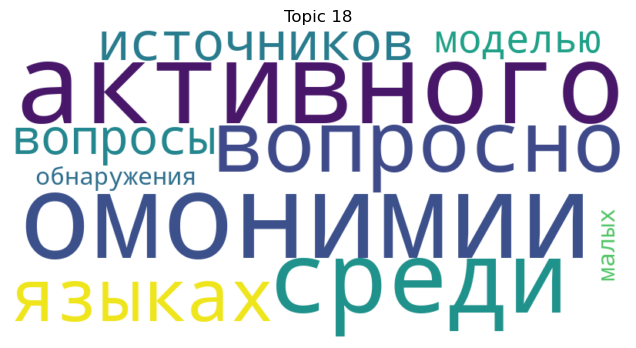

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed i

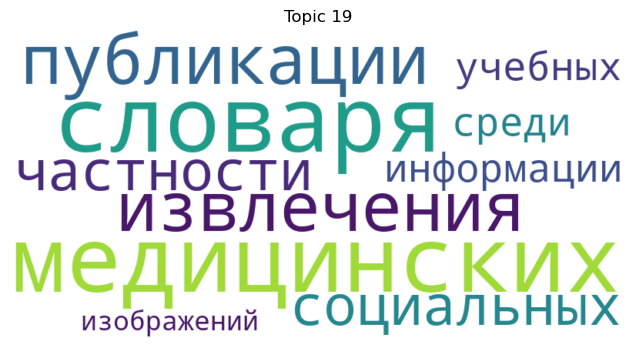

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientatio

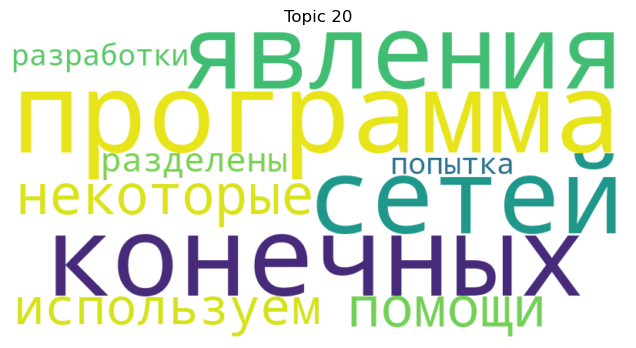

In [230]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for topic_id, topic in enumerate(lda.print_topics()):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topic[1])
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {topic_id + 1}")
    plt.axis("off")
    plt.show()

### FastText

Read 0M words
Number of words:  35
Number of labels: 0
Progress: 100.0% words/sec/thread:   10160 lr:  0.000000 avg.loss:  4.131135 ETA:   0h 0m 0s
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provid

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

                                                  Text  Cluster_Label
0    Предсказание параметров генерации ответа диало...             17
1    Использование памяти в генеративных диалоговых...             38
2    Применение методов объяснимого искусственного ...             27
3    Извелечение именованных сущностей из документо...             24
4    Автоматическое выделение лексико-семантических...             21
..                                                 ...            ...
137  Автоматическое построение графов для анализа х...              6
138  Типология прилагательных и наречная модификаци...             12
139  Методы автоматического распознавания и исправл...             10
140  Выявление значимых лингвистическиx параметров ...             11
141  Автоматическое извлечение и классификация неол...              6

[142 rows x 2 columns]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

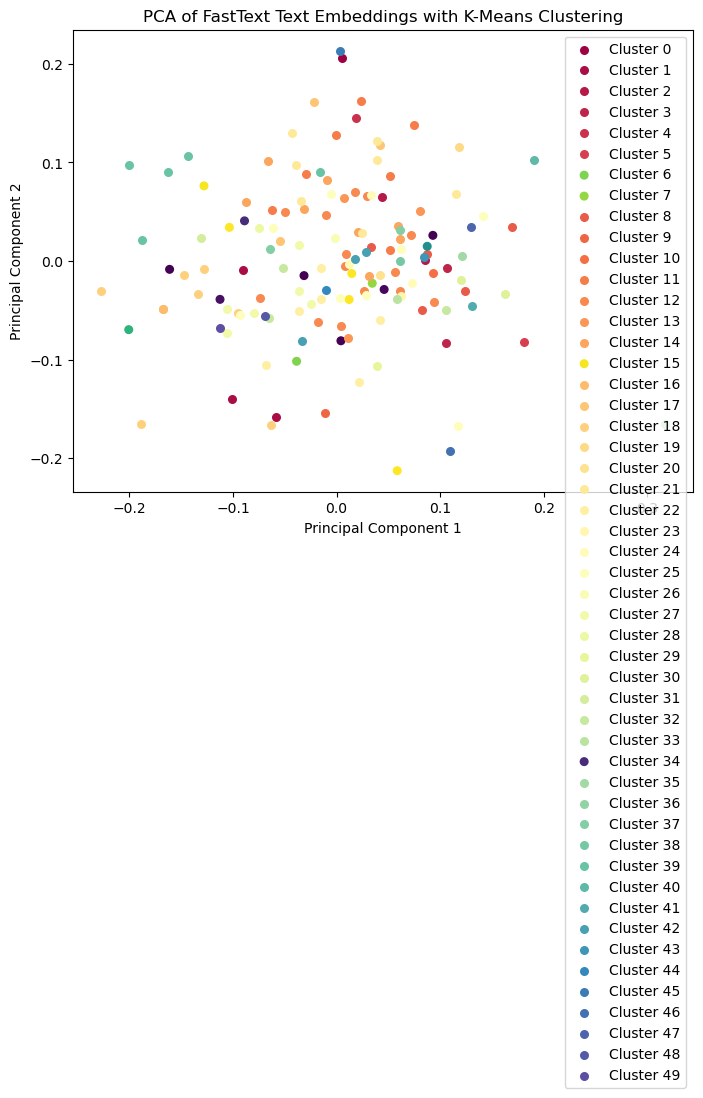

In [260]:
import fasttext

with open('text_data.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(df.name.values))

model = fasttext.train_unsupervised('text_data.txt', model='skipgram', dim=100)

embeddings = []
for text in df.name.values:
    text_embedding = model.get_sentence_vector(text)
    embeddings.append(text_embedding)

embeddings = np.array(embeddings)

num_clusters = 50
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings)
cluster_labels = kmeans.labels_

results_df = pd.DataFrame({
    'Text': texts,
    'Cluster_Label': cluster_labels
})

print(results_df)

pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)

unique_labels = set(cluster_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
plt.figure(figsize=(8, 6))
for label, color in zip(unique_labels, colors):
    plt.scatter(pca_embeddings[cluster_labels == label, 0], pca_embeddings[cluster_labels == label, 1], c=color, s=30, label=f'Cluster {label}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of FastText Text Embeddings with K-Means Clustering')
plt.legend()
plt.show()

In [389]:
results_df['Cluster_Label'].value_counts()

0    2
1    1
2    1
3    1
4    1
5    1
Name: Cluster_Label, dtype: int64

In [388]:
results_df[results_df['Cluster_Label'] == 12]['Text'].value_counts()

Series([], Name: Text, dtype: int64)

### BoW

In [383]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vec = CountVectorizer(analyzer='char', ngram_range =([2,2]), max_features=500)
bow_vecs_name = bow_vec.fit_transform(df['text_lemm'])

In [384]:
num_clusters = 25
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(bow_vecs_name)
cluster_labels = kmeans.labels_
df['Cluster_Label'] = cluster_labels

/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gennadiymakhmudov/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


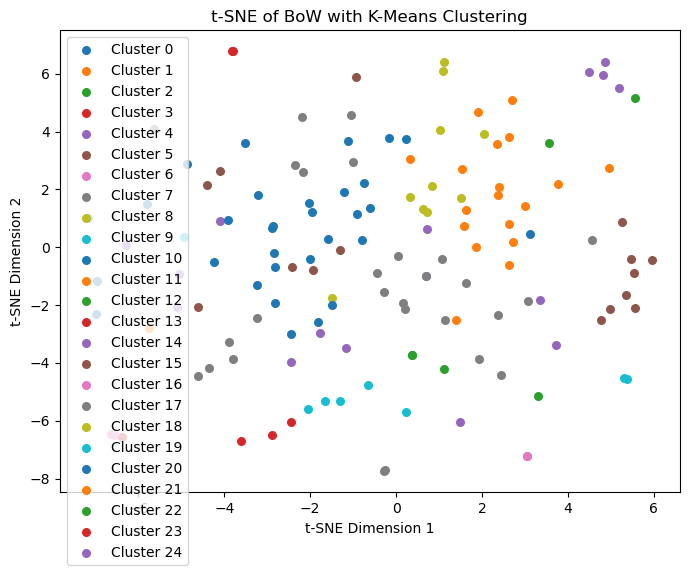

In [385]:
tsne = TSNE(n_components=2, random_state=0)
reduced_embeddings = tsne.fit_transform(bow_vecs_name)

unique_labels = set(cluster_labels)
plt.figure(figsize=(8, 6))
for label in unique_labels:
    plt.scatter(reduced_embeddings[cluster_labels == label, 0], reduced_embeddings[cluster_labels == label, 1], s=30, label=f'Cluster {label}')

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE of BoW with K-Means Clustering')
plt.legend()
plt.show()

In [386]:
df['Cluster_Label'].value_counts()

10    28
7     21
1     14
4     10
8      8
5      8
15     7
17     6
19     6
11     4
14     4
3      3
2      3
16     2
9      2
23     2
24     2
18     2
22     2
6      2
0      2
12     1
13     1
21     1
20     1
Name: Cluster_Label, dtype: int64

In [465]:
df[df['Cluster_Label'] == 10]['name'].value_counts()

Создание русскоязычной базы данных почерка на основе материалов Тотального диктанта             1
Корпус вопросов и ответов на русском языке на основе событийно-ориентированного графа знаний    1
Диалоговый менеджмент на основе классификатора речевых функций                                  1
Чувствительность языковых моделей на основе трансформеров к дискурсивным структурам             1
Рекомендация релевантных статей на основе векторной модели сети цитирований                     1
Извлечение фактов и мнений на основе материалов о Чернобыльской аварии                          1
Снятие омонимии на основе материалов НКРЯ                                                       1
Name: name, dtype: int64

### FRED-T5 (тест)

In [425]:
# from transformers import T5Tokenizer, T5Model 

# tokenizer = T5Tokenizer.from_pretrained('ai-forever/FRED-T5-1.7B')
# model = T5Model.from_pretrained('ai-forever/FRED-T5-1.7B')

In [426]:
# embeddings = []
# for text in df.annotation.values:
#     tokens = tokenizer(text, return_tensors="pt")

#     with torch.no_grad():
#         outputs = model(**tokens)
#         text_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

#     embeddings.append(text_embedding)

# embeddings = np.array(embeddings)

# num_clusters = 30
# kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(embeddings)
# cluster_labels = kmeans.labels_

# results_df = pd.DataFrame({
#     'Text': texts,
#     'Cluster_Label': cluster_labels
# })

# # print(results_df)